We import the dataset from github

In [ ]:
!git clone https://github.com/Juru-Systems/Maize_Dataset.git

Cloning into 'Maize_Dataset'...
remote: Enumerating objects: 4923, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 4923 (delta 42), reused 68 (delta 41), pack-reused 4854
Receiving objects: 100% (4923/4923), 162.57 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [ ]:
#import the data augmentatiion script
from Maize_Dataset import maize_dataset

In [ ]:
!rm -rf /content/Maize_Dataset/temp

In [ ]:
#Compile the data augmentation instance

#class encoding: binary or class
#class encoding means we split images into their respective folers i.e imgs/blight, imgs/gray_leaf....imgs/healthy.
#binary encoding means we split images into good or bad i.e: the healthy foler goes into it's own folder while all others go into the unhealthy ones.

#ratio is by [a,b,c] a is the training imgs, b is the validation folder and last is the test folder. All of them contains all the classes/binary folder in rationed way respectively.

#Since the healthy class of imgs are less than all the other classes. We can set the augmentation script to on;y create other classes to the healthy class
b = maize_dataset.compile(class_encoding='class', ratio=[.7,.2,.1], equal_ratio_to_healthy=True)  

In [ ]:
#Visualizing the output of the augmentation
b.visualise_tree

train folder
    |--class gray_leaf_spot
          |--contains 401 Original images
          |--contains 2406 Generic images
    |--class healthy
          |--contains 813 Original images
          |--contains 4878 Generic images
    |--class blight
          |--contains 802 Original images
          |--contains 4812 Generic images
    |--class common_rust
          |--contains 914 Original images
          |--contains 5484 Generic images
val folder
    |--class gray_leaf_spot
          |--contains 114 Original images
          |--contains 0 Generic images
    |--class healthy
          |--contains 232 Original images
          |--contains 0 Generic images
    |--class blight
          |--contains 229 Original images
          |--contains 0 Generic images
    |--class common_rust
          |--contains 261 Original images
          |--contains 0 Generic images
test folder
    |--class gray_leaf_spot
          |--contains 58 Original images
          |--contains 0 Generic images
    |--c

In [ ]:
!pip install keras 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np #Numpy is library to perform matrix/vector calculations
import tensorflow as tf
from Maize_Dataset import maize_dataset
from matplotlib import pyplot as plt
import cv2 #computer vision package 
from shutil import move
import os #operating system api
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import models
from tensorflow.keras import layers #import the 
from tensorflow.keras.applications import VGG16 #the model
from tensorflow.keras.optimizers import Adam
import json #json library

In [ ]:


train_data_generator =  ImageDataGenerator(rotation_range=40,
                                width_shift_range=0.2, #shift sidways randomly
                                height_shift_range=0.2, #shift upwise randomly
                                rescale=1./255, #random rescale
                                shear_range=0.2, 
                                zoom_range=0.2, #random zoom
                                horizontal_flip=True, #horizontal flip/rotation
                                fill_mode='nearest') #if the shifted sideways fill the gap with the nearest pixels


#You dont need to augment the validation data
val_data_generator =  ImageDataGenerator(rescale=1./255,)

In [ ]:
train_dataset = train_data_generator.flow_from_directory(
                                    "Maize_Dataset/temp/train/",
                                    target_size = (224, 224),
                                    class_mode = "categorical",
                                    batch_size = 32,)

Found 20510 images belonging to 4 classes.


In [ ]:
#Create val pipeline
val_dataset = val_data_generator.flow_from_directory(
                                    "Maize_Dataset/temp/val/",
                                    target_size = (224, 224),
                                    class_mode = "categorical",
                                    batch_size = 32,)

Found 836 images belonging to 4 classes.


In [ ]:
#initiate the model
a = VGG16(weights='imagenet',include_top=True,input_shape=(224, 224, 3))

553467096/553467096 [==============================] - 4s 0us/step


In [ ]:
#visual summary of the model
a.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#model input shape
a.input_shape

(None, 224, 224, 3)

In [ ]:
initial_lr = 0.00001 #learning rate
epochs=20 #number of epochs
def _model():
    conv_base = VGG16(weights='imagenet',include_top=True,input_shape=(224, 224, 3)) #base model with input 
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=4096,activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2000, activation = "relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(4, activation = 'softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer = Adam(learning_rate = initial_lr, decay = initial_lr/epochs),
              metrics=['accuracy'])
    return model

In [ ]:
model=_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 4096)              4100096   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 2000)              8194000   
                                                                 
 dropout_1 (Dropout)         (None, 2000)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 8

In [ ]:
# class LossHistory(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.metrics_json = {}

#     def on_batch_end(self, batch, logs={}):
#         steps = list(range(0,555, 50))
#         self.metrics_json[batch] = {
#             'loss' : logs.get('loss'),
#             'acc' : logs.get('accuracy')}
#         if batch in steps:
#           self.metrics_json[int(batch)]['val'] = self.model.evaluate(val_dataset)


#     def on_train_end(self, logs={}, **kwargs):
#       out_file = open("batch_metrics.json", "w+")
#       json.dump(self.metrics_json, out_file, indent = 6)
#       out_file.close()

In [ ]:
#train the model

history = model.fit(
      train_dataset, #train dataset includes input and target(x & y)
      batch_size=32,
      epochs=10, 
      verbose=1,
      validation_data=val_dataset #test the model accuracy while training without using the actual test datasets.
      ) 

Epoch 1/10
641/641 [==============================] - 389s 580ms/step - loss: 0.6890 - accuracy: 0.7669 - val_loss: 0.3682 - val_accuracy: 0.8457
Epoch 2/10
641/641 [==============================] - 355s 553ms/step - loss: 0.3495 - accuracy: 0.8439 - val_loss: 0.2796 - val_accuracy: 0.8517
Epoch 3/10
641/641 [==============================] - 354s 551ms/step - loss: 0.2181 - accuracy: 0.9204 - val_loss: 0.1771 - val_accuracy: 0.9330
Epoch 4/10
641/641 [==============================] - 352s 548ms/step - loss: 0.1475 - accuracy: 0.9490 - val_loss: 0.1449 - val_accuracy: 0.9498
Epoch 5/10
641/641 [==============================] - 353s 551ms/step - loss: 0.1225 - accuracy: 0.9571 - val_loss: 0.1495 - val_accuracy: 0.9498
Epoch 6/10
641/641 [==============================] - 352s 549ms/step - loss: 0.1019 - accuracy: 0.9644 - val_loss: 0.1385 - val_accuracy: 0.9522
Epoch 7/10
641/641 [==============================] - 351s 547ms/step - loss: 0.0876 - accuracy: 0.9703 - val_loss: 0.1433 -

In [ ]:
history.history

{'loss': [0.6889923810958862,
  0.3495279550552368,
  0.21805931627750397,
  0.14746390283107758,
  0.12245156615972519,
  0.10186389833688736,
  0.08755031228065491,
  0.08134409785270691,
  0.06883163750171661,
  0.06238321587443352],
 'accuracy': [0.7669429779052734,
  0.8439297676086426,
  0.9204290509223938,
  0.9490004777908325,
  0.9570940732955933,
  0.9643588662147522,
  0.9703071713447571,
  0.9715260863304138,
  0.9746952652931213,
  0.9774743914604187],
 'val_loss': [0.36817020177841187,
  0.2795947194099426,
  0.17709721624851227,
  0.14492875337600708,
  0.1494714915752411,
  0.13852158188819885,
  0.14327310025691986,
  0.11505045741796494,
  0.13538940250873566,
  0.12703651189804077],
 'val_accuracy': [0.8456937670707703,
  0.8516746163368225,
  0.9330143332481384,
  0.9497607946395874,
  0.9497607946395874,
  0.9521530866622925,
  0.9533492922782898,
  0.9569377899169922,
  0.9545454382896423,
  0.9629186391830444]}

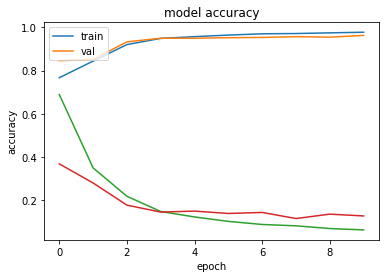

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Evaluate the model.

train_loss, train_acc = model.evaluate_generator(train_dataset, steps=9)
validation_loss, val_acc = model.evaluate_generator(val_dataset, steps=9)
print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))

<ipython-input-20-7f22f38ca42c>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_acc = model.evaluate_generator(train_dataset, steps=9)
<ipython-input-20-7f22f38ca42c>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_loss, val_acc = model.evaluate_generator(val_dataset, steps=9)


Train: 0.983, Test: 0.955


In [ ]:
#Save the model for future re-use.
model.save('maize-detector.h5')